# Detailed Examples for Coffea-Casa

## OpenData Example

In this example (which corresponds to [ADL Benchmark 1](https://github.com/CoffeaTeam/coffea-casa-tutorials/blob/master/examples/example1.ipynb)), we'll try to run a simple analysis example on the Coffea-Casa Analysis Facility. We will use the *coffea_casa* wrapper library, which allows use of pre-configured settings for HTCondor configuration and Dask scheduler/worker images.

Our goal in this toy analysis is to plot the missing transverse energy (*MET*) of all events from a sample dataset; this data was converted from 2012 CMS Open Data (17 GB, 54 million events), and is available in public EOS (root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root).

First, we need to import the *coffea* libraries used in this example:

In [1]:
import numpy as np
%matplotlib inline
from coffea import hist
import coffea.processor as processor
import awkward as ak
from coffea.nanoevents import schemas

To select the aforementioned data in a coffea-friendly syntax, we employ a dictionary of datasets, where each dataset (key) corresponds to a list of files (values):

In [2]:
fileset = {'SingleMu' : ["root://eospublic.cern.ch//eos/root-eos/benchmark/Run2012B_SingleMu.root"]}

Coffea provides the coffea.processor module, where users may write their analysis code without worrying about the details of efficient parallelization, assuming that the parallelization is a trivial map-reduce operation (e.g., filling histograms and adding them together).


In [3]:
# This program plots an event-level variable (in this case, MET, but switching it is as easy as a dict-key change). It also demonstrates an easy use of the book-keeping cutflow tool, to keep track of the number of events processed.

# The processor class bundles our data analysis together while giving us some helpful tools.  It also leaves looping and chunks to the framework instead of us.
class Processor(processor.ProcessorABC):
    def __init__(self):
        # Bins and categories for the histogram are defined here. For format, see https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Hist.html && https://coffeateam.github.io/coffea/stubs/coffea.hist.hist_tools.Bin.html
        dataset_axis = hist.Cat("dataset", "")
        MET_axis = hist.Bin("MET", "MET [GeV]", 50, 0, 100)

        # The accumulator keeps our data chunks together for histogramming. It also gives us cutflow, which can be used to keep track of data.
        self._accumulator = processor.dict_accumulator({
            'MET': hist.Hist("Counts", dataset_axis, MET_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        # This is where we do our actual analysis. The dataset has columns similar to the TTree's; events.columns can tell you them, or events.[object].columns for deeper depth.
        dataset = events.metadata["dataset"]
        MET = events.MET.pt

        # We can define a new key for cutflow (in this case 'all events'). Then we can put values into it. We need += because it's per-chunk (demonstrated below)
        output['cutflow']['all events'] += ak.size(MET)
        output['cutflow']['number of chunks'] += 1

        # This fills our histogram once our data is collected. The hist key ('MET=') will be defined in the bin in __init__.
        output['MET'].fill(dataset=dataset, MET=MET)
        return output

    def postprocess(self, accumulator):
        return accumulator

With our data in our fileset variable and our processor ready to go, we simply need to connect to the Dask Labextention-powered cluster available within the Coffea-Casa Analysis Facility @ T2 Nebraska. This can be done by dragging the scheduler into the notebook, or by manually typing the following:

In [4]:
from dask.distributed import Client
client = Client("tls://localhost:8786")

Then we bundle everything up to run our job, making use of the Dask executor. To do this, we must point to a client within executor_args.

In [5]:
executor = processor.DaskExecutor(client=client)
run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                       savemetrics=True
                      )

output, metrics = run(fileset, "Events", processor_instance=Processor())

The final step is to generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional arguments to fill the graph (default is a line).

<AxesSubplot:xlabel='MET [GeV]', ylabel='Counts'>

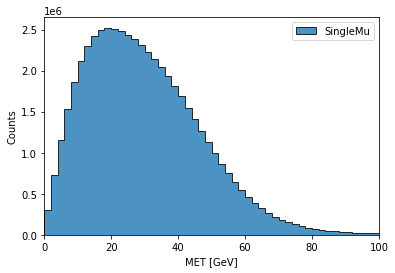

In [6]:
hist.plot1d(output['MET'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

## CMS Example

**This section applies only to the CMS Coffea-Casa instance.**

Now we will try to run a short example, using CMS data, which corresponds to plotting the `dimuon Z-peak <https://github.com/CoffeaTeam/coffea-casa-tutorials/blob/master/examples/zpeak_example.ipynb>`_. We use dimuon data which consists of ~3 million events at ~2.7 GB which belongs to the ``/DoubleMuon/Run2018A-02Apr2020-v1/NANOAOD`` dataset.

We import some common coffea libraries used in this example:

In [7]:
import numpy as np
from coffea import hist
import coffea.processor as processor
%matplotlib inline

To select the aforementioned data in a coffea-friendly syntax, we employ a dictionary of datasets, where each dataset (key) corresponds to a list of files (values):

In [8]:
fileset = {'DoubleMu' : ['root://xcache//store/data/Run2018A/DoubleMuon/NANOAOD/02Apr2020-v1/30000/0555868D-6B32-D249-9ED1-6B9A6AABDAF7.root',
                        'root://xcache//store/data/Run2018A/DoubleMuon/NANOAOD/02Apr2020-v1/30000/07796DC0-9F65-F940-AAD1-FE82262B4B03.root',
                        'root://xcache//store/data/Run2018A/DoubleMuon/NANOAOD/02Apr2020-v1/30000/09BED5A5-E6CC-AC4E-9344-B60B3A186CFA.root']}

Coffea provides the coffea.processor module, where users may write their analysis code without worrying about the details of efficient parallelization, assuming that the parallelization is a trivial map-reduce operation (e.g., filling histograms and adding them together).

In [9]:
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Dataset")
        dimu_mass_axis = hist.Bin("dimu_mass", "$\mu\mu$ Mass [GeV]", 50, 20, 120)

        self._accumulator = processor.dict_accumulator({
            'dimu_mass': hist.Hist("Counts", dataset_axis, dimu_mass_axis),
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        output = self.accumulator.identity()

        dataset = events.metadata["dataset"]

        mu = events.Muon
        # Select events with 2 muons whose charges cancel out (Zs are charge-neutral).
        dimu_neutral = mu[(ak.num(mu) == 2) & (ak.sum(mu.charge, axis=1) == 0)]
        # Add together muon pair p4's, find dimuon mass.
        dimu_mass = (dimu_neutral[:, 0] + dimu_neutral[:, 1]).mass
        # Plot dimuon mass.
        output['dimu_mass'].fill(dataset=dataset, dimu_mass=dimu_mass)
        return output

    def postprocess(self, accumulator):
        return accumulator

With our data in our fileset variable and our processor ready to go, we simply need to connect to the Dask Labextention-powered cluster available within the Coffea-Casa Analysis Facility @ T2 Nebraska. This can be done by dragging the scheduler into the notebook, or by manually typing the following:

In [10]:
from dask.distributed import Client
client = Client("tls://localhost:8786")

Then we bundle everything up to run our job, making use of the Dask executor. To do this, we must point to a client within executor_args.

In [11]:
executor = processor.DaskExecutor(client=client)
run = processor.Runner(executor=executor,
                        schema=schemas.NanoAODSchema,
                      )

output = run(fileset, "Events", processor_instance=Processor())

The final step is to generates a 1D histogram from the data output to the 'MET' key. fill_opts are optional arguments to fill the graph (default is a line).

<AxesSubplot:xlabel='$\\mu\\mu$ Mass [GeV]', ylabel='Counts'>

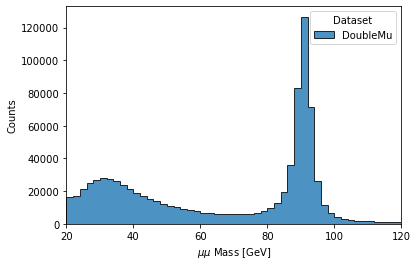

In [12]:
hist.plot1d(output['dimu_mass'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})